# La Quiniela Machine Learning Analysis

### Authors:

Jaume Reixach Pérez 

Ferran Iglesias Cels 

Pau Rodrigo Parés


On this notebook we're going to build a model to predict the results of La Liga matches, from Spain. To train the model we will use data from La Liga matches from 1928-1929 until 2018-2019 with the intention of predicting the results of the 2020-2021 season.

The model of choice is a random forest which uses the name of the home team, the name of the away team, the current rank of the home team and the current rank of the away team as predictors.

First of all we get the data from the sqlite database it is stored in. Doing this we obtain a dataset in which each row represents a match. After obtaining this dataset we modify it in order to get for each match, the ranking of each of the two teams in the current matchday of the season of the match. We do this, as we will use this two ranking values as predictors for our model.

### DATA PREPARATION

In [1]:
#Firts of all import the libraries we will use

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data from Sqlite database

con = sqlite3.connect("laliga.sqlite")
df = pd.read_sql_query("SELECT * FROM Matches", con)
con.close()

So now we are able to hangling the data and we can start to prepare it for the model. First of all we are going to use the code from exercise 10 of LaLigaDataAnalysis.ipynb to get the ranking of each team in each matchday of the season. We will use this ranking to train our model.

In [3]:

#modify df to add the rank of each team at the current matchday of each match
df.dropna(inplace = True)
df["home_score"] = df.apply(lambda x: int(x["score"].split(":")[0]), axis = 1)
df["away_score"] = df.apply(lambda x: int(x["score"].split(":")[1]), axis = 1)
df["winner"] = df.apply(lambda x : x["home_team"] if(x["home_score"] > x["away_score"]) else (x["away_team"] if(x["home_score"] < x["away_score"]) else "NaN"), axis = 1)
df["loser"] = df.apply(lambda x : x["home_team"] if(x["home_score"] < x["away_score"]) else (x["away_team"] if(x["home_score"] > x["away_score"]) else "NaN"), axis = 1)
df_ht = df.copy()
df_ht['team'] = df['home_team']
df_aw = df.copy()
df_aw['team'] = df['away_team']
df_total = pd.concat([df_ht,df_aw])
df_total = df_total.sort_values(by = ['season', 'division', 'matchday', 'score'])
df_total['W'] = df_total.apply(lambda x : 1 if x['winner'] == x['team'] else 0, axis = 1)
df_total['T'] = df_total.apply(lambda x : 1 if x['loser'] == 'NaN' else 0, axis = 1)
df_total['W'] = df_total.groupby(['season', 'division', 'team'])['W'].cumsum()
df_total['T'] = df_total.groupby(['season', 'division', 'team'])['T'].cumsum()
df_total['Pts'] = 3 * df_total['W'] + df_total['T']
df_total['rank'] = df_total.groupby(['division','season','matchday'])['Pts'].rank(method = 'min', ascending=False)
df_total = df_total.sort_index()
df_total_ht = df_total.loc[df_total['home_team'] == df_total['team']]
df_total_aw = df_total.loc[df_total['away_team'] == df_total['team']]
df['home_team_rank'] = df_total_ht['rank']
df['away_team_rank'] = df_total_aw['rank']
df.drop(columns = ['winner', 'loser'], inplace = True)
df.drop(columns = ['home_score', 'away_score'], inplace = True) 

We can take a look at how df looks like now. As we can see, we have the columns home_team_rank and away_team_rank which contain the rank of each team at the corresponding matchday.

In [4]:
df.sample(10)

,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank
39857,2002-2003,2,42,6/29/03,9:00 PM,Getafe,Córdoba CF,1:1,10.0,15.0
23259,2013-2014,1,25,2/22/14,4:00 PM,Real Madrid,Elche CF,3:0,1.0,14.0
19795,2004-2005,1,20,1/23/05,5:00 PM,Dep. La Coruña,Espanyol,4:1,10.0,5.0
44803,2013-2014,2,30,3/15/14,6:15 PM,Recr. Huelva,RM Castilla,2:3,3.0,14.0
44008,2011-2012,2,41,5/27/12,8:00 PM,FC Cartagena,Villarreal CF B,6:2,20.0,12.0
24012,2015-2016,1,24,2/13/16,10:05 PM,Dep. La Coruña,Real Betis,2:2,9.0,13.0
18116,2000-2001,1,4,10/1/00,8:00 PM,Valencia,UD Las Palmas,5:1,2.0,17.0
21265,2008-2009,1,15,12/14/08,5:00 PM,Athletic,Sporting Gijón,3:0,14.0,11.0
21842,2009-2010,1,35,5/1/10,6:00 PM,Dep. La Coruña,Real Zaragoza,0:1,9.0,15.0
41203,2005-2006,2,38,5/21/06,7:00 PM,Xerez CD,Real Murcia,2:0,7.0,14.0


We are also going to add a column which represents the winner of each match using the following notation:

FOR TRAINING PURPOSES:

- 0: Home team wins
- 1: Draw
- 2: Away team wins

This is the column we will want our model to predict.

<font color='red'>WARNING</font>

This is the notations used to train the model, because for this we need integer values. However, the output of the model on the cli.py and on the fuction that predicts the results of a given seasson and matchday is the classical of La Quiniela, which is the following:

FOR OUTPUT:

- 1: Home team wins
- X: Draw
- 2: Away team wins


In [5]:
#Drop the null values
df = df.dropna()
#Add a column with the winner of the match
df['winner'] = df['score'].str.split(':').str[0].astype(int) - df['score'].str.split(':').str[1].astype(int)
df['winner'] = np.where(df['winner'] > 0, 0, np.where(df['winner'] < 0, 2, 1))
df.sample(10)

,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank,winner
44669,2013-2014,2,18,12/14/13,6:00 PM,CE Sabadell,Real Zaragoza,1:0,18.0,10.0,0
44183,2012-2013,2,15,11/25/12,5:00 PM,Ponferradina,SD Huesca,2:1,12.0,18.0,0
24167,2016-2017,1,1,8/22/16,10:00 PM,Valencia,UD Las Palmas,2:4,14.0,1.0,2
18697,2001-2002,1,24,2/6/02,10:30 PM,UD Las Palmas,Real Betis,0:0,13.0,7.0,1
44867,2013-2014,2,36,4/26/14,6:00 PM,Sporting Gijón,CD Lugo,2:0,6.0,11.0,0
47365,2019-2020,2,11,10/12/19,12:00 PM,Girona,Elche CF,0:2,7.0,7.0,2
43452,2010-2011,2,33,4/9/11,6:00 PM,FC Cartagena,Recr. Huelva,1:3,8.0,15.0,2
19754,2004-2005,1,16,12/19/04,5:00 PM,RCD Mallorca,CA Osasuna,1:2,19.0,7.0,2
23758,2014-2015,1,37,5/17/15,7:00 PM,Villarreal,Málaga CF,2:1,6.0,8.0,0
22489,2011-2012,1,24,2/18/12,8:00 PM,Real Madrid,Racing,4:0,1.0,18.0,0


In order to input the data into the model we are going to assign to each team a number, using a dictionary. We will modify df in order to add a column with the home team number and a column with the away team number. 

In [6]:
#Assing to each team a number
teams = [df['home_team'].unique()]
#Convert the array to a list
teams = teams[0].tolist()

#Create a dictionary with the teams and their number
teams_dict = {}
for i in range(len(teams)):
    teams_dict[teams[i]] = i

#Create a new column with the number of the home team
df['home_team_num'] = df['home_team'].map(teams_dict)
#Create a new column with the number of the away team
df['away_team_num'] = df['away_team'].map(teams_dict)
df['winner'] = df['winner'].astype(int)
df['home_team_num'] = df['home_team_num'].astype(int)
df['away_team_num'] = df['away_team_num'].astype(int)

df.sample(10)


,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank,winner,home_team_num,away_team_num
42450,2008-2009,2,26,2/28/09,6:30 PM,Girona,Córdoba CF,1:1,11.0,18.0,1,43,41
21689,2009-2010,1,20,1/30/10,8:00 PM,Sporting Gijón,Barcelona,0:1,11.0,1.0,2,35,14
46859,2018-2019,2,7,9/29/18,4:00 PM,CD Lugo,RCD Mallorca,1:1,12.0,7.0,1,74,20
22306,2011-2012,1,5,9/22/11,8:00 PM,Espanyol,Getafe,1:0,6.0,16.0,0,5,31
46570,2017-2018,2,22,1/14/18,6:00 PM,CyD Leonesa,Lorca FC,2:1,15.0,20.0,0,80,79
42278,2008-2009,2,10,11/2/08,6:00 PM,SD Eibar,Levante,0:0,14.0,12.0,1,40,30
25520,2019-2020,1,23,2/8/20,4:00 PM,Getafe,Valencia,3:0,3.0,6.0,0,31,2
46386,2017-2018,2,6,9/23/17,4:00 PM,Reus Deportiu,CA Osasuna,0:0,15.0,9.0,1,77,22
18930,2002-2003,1,10,11/17/02,5:00 PM,Athletic,Rayo Vallecano,2:1,12.0,17.0,0,13,25
47570,2019-2020,2,29,2/23/20,6:15 PM,Extremadura,CD Mirandés,3:2,20.0,9.0,0,81,73


### MODEL CONSRTUCTION AND TRAINING

After the data is prepared, we are able to predict the model, the data will be:

- X: home_team_rank, away_team_rank, home_team_number, away_team_number
- y: winner

The goal is to make a model to predict the winner between two teams on a given matchday of a given season. 

Now we will use the constructed model to predict the results of season 2019-2020 or 2020-2021. So the training set will be the data from seasons 1928-1929 until 2018-2019 and the test set will be the data from season 2019-2020. On this model analysis we will focus on predictions of the 2019-2020 season. The accuracy of this prediction will be the model's measure of quality.

We have decided to train our model depending on the division, because on the model, we consider the ranking of the teams as a predictor, and the ranking of the teams is different depending on the division. It's also true that if there is a team who had played on the first division and then it was relegated to the second division, the ranking of the team will be different on the first and second division.

so we will train two models, one for each division, to avoid introducing bias on the model. In fact we will have two models, one trained with first division data and one trained with second division data. For the first division predictions the first model will be used and for the second division predictions the second one.

The model used is a random forest classifier with 100 trees and the 4 predictors mentioned before.

#### TRAINING AND PREDICTING THE 2019-2020 RESULTS FOR FIRST DIVISION

Firts of all we define the model and train it with the data from the first division.

In [7]:
# We define the training data
train_data_fd = df[(df['season'] < '2019-2020') & (df['division'] == 1)] 

# We define the model
forest_model_fd = RandomForestRegressor(random_state=100, n_estimators=100)

# We select the predictors and the variable we want to predict
X_train_fd = train_data_fd[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
Y_train_fd = train_data_fd['winner']

#We train the model
forest_model_fd.fit(X_train_fd, Y_train_fd)

RandomForestRegressor(random_state=100)

Now we have the model trained, we can use it to predict the results of the 2019-2020 season. We will use the function predict.

In [8]:
#Use the model to predict the winner of matchdays of the season 2019-2020 for first division

#Select the test data
season_19_20_first_division = df[(df['season'] == '2019-2020') & (df['division'] == 1)]
test_19_20_first_division = season_19_20_first_division[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]

#Test the model
season_19_20_first_division['prediction_win'] = forest_model_fd.predict(test_19_20_first_division).astype(int)

#Calculate the accuracy of the model
accuracy_19_20_first_division = (season_19_20_first_division['winner'] == season_19_20_first_division['prediction_win']).sum() / len(season_19_20_first_division)

print(f'The accuracy of the model for predicting the first division results for the 2019-2020 season is: {round(accuracy_19_20_first_division,3)}%')


The accuracy of the model for predicting the first division results for the 2019-2020 season is: 0.487%


We can see that for first division, the accuracy of the model is 48 %.

#### PREDICTING THE 2019-2020 RESULTS FOR SECOND DIVISION

Repeat the same process for the second division.

In [9]:
# We define the training data
train_data_sd = df[(df['season'] < '2019-2020') & (df['division'] == 2)] 

# We define the model
forest_model_sd = RandomForestRegressor(random_state=100, n_estimators=100)

# We select the predictors and the variable we want to predict
X_train_sd = train_data_sd[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
Y_train_sd = train_data_sd['winner']

#We train the model
forest_model_sd.fit(X_train_sd, Y_train_sd)

RandomForestRegressor(random_state=100)

In [10]:
#Use the model to predict the winner of matchdays of the season 2019-2020 for first division

#Select the test data
season_19_20_second_division = df[(df['season'] == '2019-2020') & (df['division'] == 1)]
test_19_20_second_division = season_19_20_second_division[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]

#Test the model
season_19_20_second_division['prediction_win'] = forest_model_sd.predict(test_19_20_second_division).astype(int)

#Calculate the accuracy of the model
accuracy_19_20_second_division = (season_19_20_second_division['winner'] == season_19_20_second_division['prediction_win']).sum() / len(season_19_20_second_division)


print(f'The accuracy of the model for predicting the second division results for the 2019-2020 season is: {round(accuracy_19_20_second_division,3)}%')

The accuracy of the model for predicting the second division results for the 2019-2020 season is: 0.489%


#### THE TOTAL ACCURACY OF THE MODEL IS THE AVERAGE BETWEEN ACCURACIES:

So, we can considerer the 2 models as one, and the accuracy of the total model will be the average between both.

In [11]:
total_model_accuracy = (accuracy_19_20_first_division + accuracy_19_20_second_division)/2
print(f"Total model accuracy: {round(total_model_accuracy,3)}%")

Total model accuracy: 0.488%


So we get a total accuracy of 48%. It's not a very good accuracy, but it's not bad either.

This is a very basic model, but some models need more time to be trained and it's not a good idea to train the model in each execution of the script, or also you want to compare differents models with a easy way, so using the library pickle we can save the model and load it when we want. You can use this code for exemple. 

```python

#Save both models on the same file
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump([forest_model_fd, forest_model_sd], f)

#Load the models

with open('models.pkl', 'rb') as f:
    forest_model_fd, forest_model_sd = pickle.load(f)

```	

### Defining the function that predicts the results of a given season and matchday

With the following function we can predict results for a certain matchday and division, obtaining a clean output

In [12]:
#Function to predict the winner of a matchday of 2019-2020 season
def predict_matchday(division, matchday):  
    season = '2019-2020' 
    if(division != 1 and division != 2):
            raise Exception('Prediction is only possible for first and second division')
    results = df[(df['season'] == season) & (df['division'] == division) & (df['matchday'] == matchday)]
    input_data = results[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
    
    if(division == 1): 
        results['prediction_win'] = forest_model_fd.predict(input_data).astype(int)
    elif(division == 2): 
        results['prediction_win'] = forest_model_sd.predict(input_data).astype(int)

    results['prediction_win'] = results.apply(lambda x: 'X' if x['prediction_win'] == 1 else 1 if x['prediction_win'] == 0 else x['prediction_win'], axis = 1)
    for index, row in results.iterrows():
        print(f"{row['home_team']}  vs  {row['away_team']} ----> {row['prediction_win']} ")

For example, we can predict the results for first division matchday number 1:

In [13]:
predict_matchday(1, 1)

Athletic  vs  Barcelona ----> 1 
Celta de Vigo  vs  Real Madrid ----> X 
Valencia  vs  Real Sociedad ----> 1 
RCD Mallorca  vs  SD Eibar ----> 1 
CD Leganés  vs  CA Osasuna ----> X 
Villarreal  vs  Granada CF ----> X 
Alavés  vs  Levante ----> 1 
Espanyol  vs  Sevilla FC ----> X 
Real Betis  vs  Real Valladolid ----> X 
Atlético Madrid  vs  Getafe ----> 1 


### CONCLUSIONS OF THE MODEL

As we have seen previously, the model has an accuracy of 48% in first and in second division predictions, so the mean ins 48% too. This is not a very good accuracy, but it is not bad either.

We are going to study better this accuracy, to know if the model is better predicting the results of the first division or the second division and if it is better predicting the home team wins, the away team wins or the ties.

In [14]:
#For the season 2019-2020, we will predict all the matchdays of the first division and second division and compare the results with the real results on the same dataset

season_19_20 = df[(df['season'] == '2019-2020')]
season_19_20['prediction_win'] = 0
season_19_20['prediction_win'] = season_19_20['prediction_win'].astype(int)
season_19_20['prediction_win'] = season_19_20.apply(lambda row: forest_model_fd.predict([[row['home_team_num'], row['away_team_num'], row['home_team_rank'], row['away_team_rank']]]) if row['division'] == 1 else forest_model_sd.predict([[row['home_team_num'], row['away_team_num'], row['home_team_rank'], row['away_team_rank']]]), axis=1)
season_19_20['prediction_win'] = season_19_20['prediction_win'].astype(int)

#Now we will to compact the information on a single data frame. We only want the columns season, division, matchday, home_team, away_team, winner and prediction_win
season_19_20 = season_19_20[['season', 'division', 'matchday', 'home_team', 'away_team', 'winner', 'prediction_win']]
season_19_20.head()


,season,division,matchday,home_team,away_team,winner,prediction_win
25298,2019-2020,1,1,Athletic,Barcelona,0,0
25299,2019-2020,1,1,Celta de Vigo,Real Madrid,2,1
25300,2019-2020,1,1,Valencia,Real Sociedad,1,0
25301,2019-2020,1,1,RCD Mallorca,SD Eibar,0,0
25302,2019-2020,1,1,CD Leganés,CA Osasuna,2,1


In [15]:
#We will now calculate the accuracy of the model for each match
season_19_20['accuracy'] = season_19_20['winner'] == season_19_20['prediction_win']
season_19_20.head()

,season,division,matchday,home_team,away_team,winner,prediction_win,accuracy
25298,2019-2020,1,1,Athletic,Barcelona,0,0,True
25299,2019-2020,1,1,Celta de Vigo,Real Madrid,2,1,False
25300,2019-2020,1,1,Valencia,Real Sociedad,1,0,False
25301,2019-2020,1,1,RCD Mallorca,SD Eibar,0,0,True
25302,2019-2020,1,1,CD Leganés,CA Osasuna,2,1,False


So let's see in what situations the model is good and in what situations it is bad. If it predicts better the wins, loses or draws


In [16]:

#Count the total number of home wins predicted by the model and the real number of home wins
home_wins_predcited = season_19_20['prediction_win'].value_counts()[0]
home_wins_real = season_19_20['winner'].value_counts()[0]
home_wins_correct = season_19_20[(season_19_20['winner'] == 0) & (season_19_20['prediction_win'] == 0)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting home wins
home_wins_accuracy = (home_wins_predcited / home_wins_real) * 100
home_wins_accuracy_real = (home_wins_correct/ home_wins_real) * 100

#Count the total number of tie wins predicted by the model and the real number of tie wins
tie_predcited = season_19_20['prediction_win'].value_counts()[1]
tie_real = season_19_20['winner'].value_counts()[1]
tie_correct = season_19_20[(season_19_20['winner'] == 1) & (season_19_20['prediction_win'] == 1)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting tie wins
tie_accuracy = (tie_predcited / tie_real) * 100
tie_accuracy_real = (tie_correct / tie_real) * 100

#Count the total number of away wins predicted by the model and the real number of away wins
away_wins_predcited = season_19_20['prediction_win'].value_counts()[2]
away_wins_real = season_19_20['winner'].value_counts()[2]
away_wins_correct = season_19_20[(season_19_20['winner'] == 2) & (season_19_20['prediction_win'] == 2)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting away wins
away_wins_accuracy = (away_wins_predcited / away_wins_real) * 100
away_wins_accuracy_real = (away_wins_correct / away_wins_real) * 100



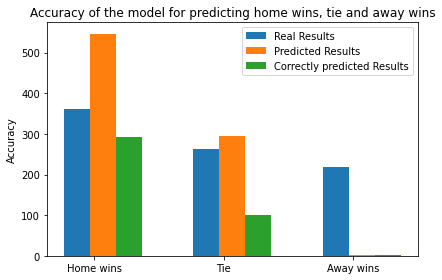

Accuracy of the model for predicting home wins: 80.663%
Accuracy of the model for predicting tie: 38.55%
Accuracy of the model for predicting away wins: 0.459%
Total model accuracy: 0.488%


In [17]:

#Let's represent the real results, the predicted results and the correctlly predicted results in a bar plot

labels = ['Home wins', 'Tie', 'Away wins']
real_accuracy = [home_wins_real, tie_real, away_wins_real]
predicted_accuracy = [home_wins_predcited, tie_predcited, away_wins_predcited]
correctly_predicted_accuracy = [home_wins_correct, tie_correct, away_wins_correct]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/3, real_accuracy, width, label='Real Results')
rects2 = ax.bar(x + width/3, predicted_accuracy, width, label='Predicted Results')
rects3 = ax.bar(x + 4*width/3, correctly_predicted_accuracy, width, label='Correctly predicted Results')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the model for predicting home wins, tie and away wins')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

#Print the accuracy of the model for predicting with only one decimal   
print(f"Accuracy of the model for predicting home wins: {round(home_wins_accuracy_real, 3)}%")
print(f"Accuracy of the model for predicting tie: {round(tie_accuracy_real, 3)}%")
print(f"Accuracy of the model for predicting away wins: {round(away_wins_accuracy_real, 3)}%")
print(f"Total model accuracy: {round(total_model_accuracy,3)}%")

So now we can see that the model has a different behavior predicting each situation.

For home wins the accuracy is of 80.6 %. That's not bad at all but the problem is that there are a lot of home wins predicted that are not true. If we talk about tie, the accuracy is 38.55 %, and the proportions between the real values, the predicted and the correctly predicted are more or less the same than home wins in proportion. The worts part of the model is predicting the away wins. This accuracy is of 0.48 % and there is only 1 correct prediciton. So the model is not good predicting the away wins.

Watching the plot we can think that the error of away wins is shared between the home wins and the ties. So for this, both cases have more predicted values than real values.

In fact, it's normal that the model have a lot of uncertainty beacuse footbal is a very random sport, and it's very difficult to predict it. Anyway it can be possible that the data used to train is not well related because there is no relation between the fotball played on 1950 and the football played on 2020.